In [2]:
import torch

embeddings = torch.load('embeddings.pt')
print(len(embeddings))
print(len(embeddings[0]))
print(type(embeddings[0][0]))

7100
17
<class 'torch.Tensor'>


In [3]:
import pandas as pd

df_train = pd.read_csv('ECHR_Dataset/train.csv')
df_train = df_train[['text','label']]
df_train.head(10)

,text,label
0,7. On 28 September 1994 the applicant's husban...,0
1,8. The applicant was born in 1974 and lives in...,0
2,"5. The first applicant, Mr Ivan Dvořáček, was ...",1
3,4. The applicant was born in 1959 and lives in...,1
4,6. The applicant was born in 1946.7. On 14 Aug...,1
5,6. The applicant was born in 1939 and lives in...,1
6,4. The applicant lives in Vrlika.5. He is a se...,0
7,8. Mr lives at Höchst in Vorarlberg.9. On 7 No...,1
8,5. The applicant was born in 1961 and is curre...,1
9,"The applicant, Curtis Francis Warren, is a Uni...",0


In [4]:
import numpy as np
avg_embeddings = {}
for i in range(len(embeddings)):
    avg_embeddings[i] = torch.mean(torch.stack(embeddings[i], dim=0).reshape(-1,768), dim=0)

In [5]:
#cat_embeddings = {}
#for i in range(len(embeddings)):
#    cat_embeddings[i] = torch.cat(embeddings[i], dim=-1)

In [6]:
# check all the avgembeddings have the same shape
print(avg_embeddings[0].shape)
for i in range(len(avg_embeddings)):
    if avg_embeddings[i].shape != avg_embeddings[0].shape:
        print(avg_embeddings[i].shape)
        
        

torch.Size([768])


In [7]:
df_train["embedding"] = [ avg_embeddings[i] for i in range(len(avg_embeddings)) ]
df_train.head(10)

,text,label,embedding
0,7. On 28 September 1994 the applicant's husban...,0,"[tensor(-0.3084), tensor(-0.2308), tensor(-0.3..."
1,8. The applicant was born in 1974 and lives in...,0,"[tensor(-0.6178), tensor(0.0757), tensor(0.229..."
2,"5. The first applicant, Mr Ivan Dvořáček, was ...",1,"[tensor(-0.4491), tensor(0.0542), tensor(0.306..."
3,4. The applicant was born in 1959 and lives in...,1,"[tensor(-0.8093), tensor(-0.5928), tensor(-0.6..."
4,6. The applicant was born in 1946.7. On 14 Aug...,1,"[tensor(-0.4574), tensor(-0.0582), tensor(0.27..."
5,6. The applicant was born in 1939 and lives in...,1,"[tensor(-0.4897), tensor(-0.2227), tensor(-0.6..."
6,4. The applicant lives in Vrlika.5. He is a se...,0,"[tensor(-0.3480), tensor(-0.0416), tensor(-0.0..."
7,8. Mr lives at Höchst in Vorarlberg.9. On 7 No...,1,"[tensor(-0.5193), tensor(-0.1316), tensor(-0.0..."
8,5. The applicant was born in 1961 and is curre...,1,"[tensor(-0.7300), tensor(-0.3040), tensor(0.02..."
9,"The applicant, Curtis Francis Warren, is a Uni...",0,"[tensor(-0.5262), tensor(-0.3986), tensor(-0.5..."


In [35]:
type(df_train['embedding'])

pandas.core.series.Series

In [37]:
# use pytorch to classify the lables with the embeddings
from sklearn.neural_network import MLPClassifier 
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV  
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import numpy as np

x_train, x_test, y_train, y_test = train_test_split( df_train['embedding'], df_train['label'], test_size=0.2, random_state=42)

# Convert pandas series to numpy arrays
x_train = np.vstack(x_train)
x_test = np.vstack(x_test)


scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Define the parameter grid
param_grid = {
    'hidden_layer_sizes': [(128,), (64, 64), (128, 64, 32)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
}

# Initialize the MLPClassifier
mlp = MLPClassifier(random_state=42, max_iter=500)

# Initialize GridSearchCV
grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(x_train, y_train)

# Print the best parameters found
print("Best parameters:", grid_search.best_params_)

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
test_accuracy = best_model.score(x_test, y_test)
print("Test accuracy:", test_accuracy)
print(classification_report(y_test, best_model.predict(x_test)))

/Users/lilf4p/.pyenv/versions/3.10.11/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/lilf4p/.pyenv/versions/3.10.11/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import numpy as np
from tqdm import tqdm

# Define the neural network model
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# Assuming df_train['embedding'] contains embeddings as NumPy arrays and df_train['label'] contains corresponding labels

# Convert pandas series to numpy arrays
X = np.vstack(df_train['embedding'])
y = df_train['label'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=23)

# Perform feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Move tensors to GPU if available
device = torch.device('mps')
X_train_tensor = X_train_tensor.to(device)
X_val_tensor = X_val_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

# Define hyperparameters
input_size = X_train.shape[1]
hidden_size1 = 128
hidden_size2 = 64
num_classes = len(np.unique(y_train))

# Initialize the model
model = NN().to(device)
print(model)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

# Training the model
num_epochs = 20
batch_size = 32

best_val_accuracy = 0.0
for epoch in range(num_epochs):
    model.train()  # Set the model to train mode
    loop = tqdm(enumerate(range(0, len(X_train_tensor), batch_size)), total=len(X_train_tensor)//batch_size)
    for i, batch_start in loop:
        inputs = X_train_tensor[batch_start:batch_start+batch_size]
        targets = y_train_tensor[batch_start:batch_start+batch_size]

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    # Evaluate on validation set
    model.eval()
    with torch.no_grad():
        outputs = model(X_val_tensor)
        _, predicted = torch.max(outputs, 1)
        val_accuracy = torch.sum(predicted == y_val_tensor).item() / len(y_val_tensor)
    
    print(f'Validation Accuracy after epoch {epoch+1}: {val_accuracy:.4f}')

    # Save the model with the best validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_state = model.state_dict()

# Load the best model state
model.load_state_dict(best_model_state)

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)

# Print classification report
print(classification_report(y_test_tensor.cpu().numpy(), predicted.cpu().numpy()))


NN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=768, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Epoch [1/20], Loss: 0.5542: 100%|██████████| 142/142 [00:03<00:00, 41.69it/s] 


Validation Accuracy after epoch 1: 0.6787


Epoch [2/20], Loss: 0.4108: 100%|██████████| 142/142 [00:01<00:00, 141.46it/s]


Validation Accuracy after epoch 2: 0.7218


Epoch [3/20], Loss: 0.3450: 100%|██████████| 142/142 [00:01<00:00, 139.84it/s]


Validation Accuracy after epoch 3: 0.7350


Epoch [4/20], Loss: 0.3098: 100%|██████████| 142/142 [00:01<00:00, 138.01it/s]


Validation Accuracy after epoch 4: 0.7456


Epoch [5/20], Loss: 0.2923: 100%|██████████| 142/142 [00:01<00:00, 139.15it/s]


Validation Accuracy after epoch 5: 0.7509


Epoch [6/20], Loss: 0.2641: 100%|██████████| 142/142 [00:01<00:00, 137.57it/s]


Validation Accuracy after epoch 6: 0.7500


Epoch [7/20], Loss: 0.2503: 100%|██████████| 142/142 [00:01<00:00, 139.09it/s]


Validation Accuracy after epoch 7: 0.7553


Epoch [8/20], Loss: 0.2334: 100%|██████████| 142/142 [00:01<00:00, 138.32it/s]


Validation Accuracy after epoch 8: 0.7606


Epoch [9/20], Loss: 0.2175: 100%|██████████| 142/142 [00:01<00:00, 131.80it/s]


Validation Accuracy after epoch 9: 0.7685


Epoch [10/20], Loss: 0.2033: 100%|██████████| 142/142 [00:01<00:00, 138.84it/s]


Validation Accuracy after epoch 10: 0.7694


Epoch [11/20], Loss: 0.1907: 100%|██████████| 142/142 [00:01<00:00, 132.61it/s]


Validation Accuracy after epoch 11: 0.7702


Epoch [12/20], Loss: 0.1815: 100%|██████████| 142/142 [00:01<00:00, 137.58it/s]


Validation Accuracy after epoch 12: 0.7702


Epoch [13/20], Loss: 0.1667: 100%|██████████| 142/142 [00:01<00:00, 140.23it/s]


Validation Accuracy after epoch 13: 0.7729


Epoch [14/20], Loss: 0.1565: 100%|██████████| 142/142 [00:01<00:00, 131.66it/s]


Validation Accuracy after epoch 14: 0.7746


Epoch [15/20], Loss: 0.1400: 100%|██████████| 142/142 [00:01<00:00, 139.60it/s]


Validation Accuracy after epoch 15: 0.7738


Epoch [16/20], Loss: 0.1323: 100%|██████████| 142/142 [00:01<00:00, 137.71it/s]


Validation Accuracy after epoch 16: 0.7720


Epoch [17/20], Loss: 0.1200: 100%|██████████| 142/142 [00:01<00:00, 135.50it/s]


Validation Accuracy after epoch 17: 0.7764


Epoch [18/20], Loss: 0.1118: 100%|██████████| 142/142 [00:01<00:00, 136.26it/s]


Validation Accuracy after epoch 18: 0.7729


Epoch [19/20], Loss: 0.1009: 100%|██████████| 142/142 [00:01<00:00, 134.38it/s]


Validation Accuracy after epoch 19: 0.7738


Epoch [20/20], Loss: 0.0913: 100%|██████████| 142/142 [00:01<00:00, 138.74it/s]


Validation Accuracy after epoch 20: 0.7755
              precision    recall  f1-score   support

           0       0.78      0.81      0.79       728
           1       0.79      0.76      0.78       692

    accuracy                           0.79      1420
   macro avg       0.79      0.79      0.79      1420
weighted avg       0.79      0.79      0.79      1420



Class Distribution:
label
1    3551
0    3549
Name: count, dtype: int64


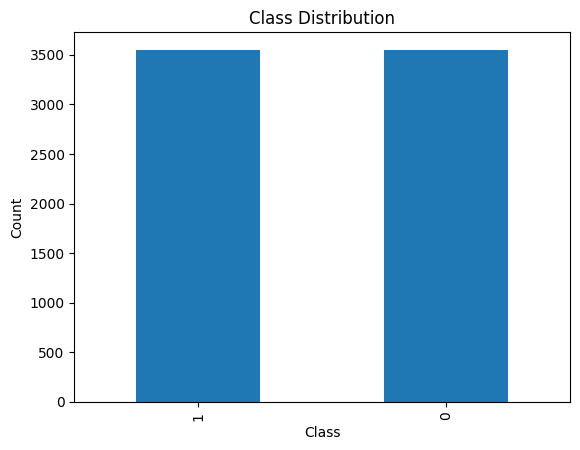

In [24]:
import matplotlib.pyplot as plt
# Compute the class distribution
class_distribution = df_train['label'].value_counts()

# Print the class distribution
print("Class Distribution:")
print(class_distribution)

# Plot the class distribution
class_distribution.plot(kind='bar', title='Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()